### 1. Carga de librerias

In [207]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

### 2. Carga de files

In [208]:
df_sales_original = pd.read_csv('item_sales.csv')

In [209]:
df_prices_original = pd.read_csv('item_prices.csv')

In [210]:
df_calendar_original = pd.read_csv('daily_calendar_with_events.csv')

In [211]:
df_prices = df_prices_original.copy()

In [212]:
df_calendar = df_calendar_original.copy()

## 3. Exploracion de dataframes

#### 3.1. df_calendar

Se vio:
- Columnas que coincidian con los demas df, y se encontro que matchea la columna "d" con df_sales.
- Fiestas, y se vio que se podrian agregar Navidad y 4 de Julio.
- No se observan duplicados
- Se observa que las semanas empiezan el dia sabado, y teniendo en cuenta la cantidad de dias dividido 7 hay 273 semanas

In [213]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         1913 non-null   object
 1   weekday      1913 non-null   object
 2   weekday_int  1913 non-null   int64 
 3   d            1913 non-null   object
 4   event        26 non-null     object
dtypes: int64(1), object(4)
memory usage: 74.9+ KB


In [214]:
df_calendar

,date,weekday,weekday_int,d,event
0,2011-01-29,Saturday,1,d_1,NaN
1,2011-01-30,Sunday,2,d_2,NaN
2,2011-01-31,Monday,3,d_3,NaN
3,2011-02-01,Tuesday,4,d_4,NaN
4,2011-02-02,Wednesday,5,d_5,NaN
...,...,...,...,...,...
1908,2016-04-20,Wednesday,5,d_1909,NaN
1909,2016-04-21,Thursday,6,d_1910,NaN
1910,2016-04-22,Friday,7,d_1911,NaN
1911,2016-04-23,Saturday,1,d_1912,NaN


In [215]:
cantidad_dias= df_calendar.shape[0]
cantidad_dias

1913

In [216]:
cantidad_semanas = cantidad_dias/7
cantidad_semanas

273.2857142857143

In [217]:
df_calendar_semanas = df_calendar.copy()

In [218]:
df_calendar_semanas['date'] = pd.to_datetime(df_calendar_semanas['date'])

df_calendar_semanas['year'] = df_calendar_semanas['date'].dt.year

cant_dias_año = df_calendar_semanas['year'].value_counts()

In [219]:
cant_dias_año

year
2012    366
2013    365
2014    365
2015    365
2011    337
2016    115
Name: count, dtype: int64

In [220]:
cant_dias_año/7

year
2012    52.285714
2013    52.142857
2014    52.142857
2015    52.142857
2011    48.142857
2016    16.428571
Name: count, dtype: float64

In [221]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

sabados = df_calendar[df_calendar['weekday'] == 'Saturday']

ultimo_sabado = sabados.groupby(sabados['date'].dt.year)['date'].max().reset_index(drop=True)


In [222]:
ultimo_sabado 

0   2011-12-31
1   2012-12-29
2   2013-12-28
3   2014-12-27
4   2015-12-26
5   2016-04-23
Name: date, dtype: datetime64[ns]

In [223]:
df_calendar.duplicated().sum()

0

In [224]:
df_calendar.isnull().any()

date           False
weekday        False
weekday_int    False
d              False
event           True
dtype: bool

In [225]:
calendar_events = df_calendar.dropna()
events = calendar_events['event'].unique()
events

array(['SuperBowl', 'Ramadan starts', 'Thanksgiving', 'NewYear', 'Easter'],
      dtype=object)

#### 3.2. df_sales

- Se pueden pasar las columnas "d_" a filas para poder analizar la informacion
- se puede agregar los datos del calendar ya que los datos "d_" coinciden con el df_calendar
- Para poder agregar el precio habria que agregar una columna con "yearweek" a partir de la fecha y poder matchear con el df_prices
- Identificacion de valores unicos de items, categories, departamentos, tiendas y ciudades

In [226]:
df_sales_original

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,2,...,2,0,0,0,0,0,1,0,0,1
30486,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,6,0,...,2,1,0,2,0,1,0,0,1,0
30488,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [227]:
df_sales_description = df_sales_original.iloc[:, :7]


In [228]:
df_sales_description.nunique()

id            30490
item           3049
category          3
department        7
store            10
store_code       10
region            3
dtype: int64

In [229]:
df_sales_original.duplicated().sum()

0

In [230]:
df_sales_original.isnull().any()

id            False
item          False
category      False
department    False
store         False
              ...  
d_1909        False
d_1910        False
d_1911        False
d_1912        False
d_1913        False
Length: 1920, dtype: bool

In [231]:
items  = df_sales_original['item'].unique()
print(items)

['ACCESORIES_1_001' 'ACCESORIES_1_002' 'ACCESORIES_1_003' ...
 'SUPERMARKET_3_825' 'SUPERMARKET_3_826' 'SUPERMARKET_3_827']


In [232]:
categories = df_sales_original['category'].unique()
print(categories)

['ACCESORIES' 'HOME_&_GARDEN' 'SUPERMARKET']


In [233]:
departments = df_sales_original['department'].unique()
print(departments)

['ACCESORIES_1' 'ACCESORIES_2' 'HOME_&_GARDEN_1' 'HOME_&_GARDEN_2'
 'SUPERMARKET_1' 'SUPERMARKET_2' 'SUPERMARKET_3']


In [234]:
stores = df_sales_original['store'].unique()
print(stores)

['Greenwich_Village' 'Harlem' 'Tribeca' 'Brooklyn' 'South_End' 'Roxbury'
 'Back_Bay' 'Midtown_Village' 'Yorktown' 'Queen_Village']


In [235]:
regions = df_sales_original['region'].unique()
print(regions)

['New York' 'Boston' 'Philadelphia']


#### 3.3. df_price

- Luego de un check ampliando la tabla y viendo "items" aleatorios se puede observar que en la columna yearweek los valores estan ordenados de forma descendente en yearweer y ordenados por item, category y store_code, por lo que se podrian completar las lineas faltantes como fechas consecutivas
- Se podria incluir la columna "sell_price" en el df_sales ya que aqui tambien tenemos "item", "store_code", solo nos faltaria agregar el yearweek en df_sales
- Se observa que hay 279 semanas, 6 semanas mas que la cantidad de dias dividido 7 en el calendar
- Se observa que el valor maximo en yearweek para todas las combinaciones de item y store_code es siempre 201716 por lo que se pueden eliminar los valores nulos
- Se observo que hay una variacion grande en el item HOME_&_GARDEN_2_406 en la tienda PHI_3 por lo que se cambiaron por la moda para ese item y tienda

In [236]:
df_prices

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858
...,...,...,...,...,...
6965701,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000
6965702,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000
6965703,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000
6965704,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000


In [237]:
df_prices.isnull().value_counts()

item   category  store_code  yearweek  sell_price
False  False     False       False     False         6721786
                             True      False          243920
Name: count, dtype: int64

In [238]:
df_prices.duplicated().sum()

212120

In [239]:
duplicados_todos = df_prices[df_prices.duplicated(keep=False)]

In [240]:
duplicados_todos['yearweek'].unique()

array([nan])

In [241]:
items = df_prices['item'].unique()
print(items)

['ACCESORIES_1_001' 'ACCESORIES_1_002' 'ACCESORIES_1_003' ...
 'SUPERMARKET_3_825' 'SUPERMARKET_3_826' 'SUPERMARKET_3_827']


In [242]:
df_prices['yearweek'].unique()

array([201328., 201329., 201330., 201331., 201332., 201333., 201334.,
       201335., 201336., 201337., 201338., 201339., 201340., 201341.,
       201342., 201343., 201344., 201345., 201346., 201347., 201348.,
       201349., 201350., 201351., 201352., 201400., 201401., 201402.,
       201403., 201404., 201405., 201406., 201407., 201408., 201409.,
       201410., 201411., 201412., 201413., 201414., 201415., 201416.,
       201417., 201418., 201419., 201420., 201421., 201422., 201423.,
       201424., 201425., 201426., 201427., 201428., 201429., 201430.,
       201431., 201432., 201433., 201434., 201435., 201436., 201437.,
       201438., 201439., 201440., 201441., 201442., 201443., 201444.,
       201445., 201446., 201447., 201448., 201449., 201450., 201451.,
       201452., 201500., 201501., 201502., 201503., 201504., 201505.,
       201506., 201507., 201508., 201509., 201510., 201511., 201512.,
       201513., 201514., 201515., 201516., 201517., 201518., 201519.,
       201520., 2015

In [243]:
#cantidad de semanas

df_prices['yearweek'].nunique()

279

In [244]:
df_prices_semanas = df_prices.copy()

In [245]:
df_prices_semanas.dropna(inplace=True)

In [246]:
df_prices_semanas['yearweek'] = df_prices_semanas['yearweek'].astype(int)
df_prices_semanas['yearweek'] = df_prices_semanas['yearweek'].astype(str)

In [247]:
df_prices_semanas['year'] = df_prices_semanas['yearweek'].str[:4] 
df_prices_semanas['week'] = df_prices_semanas['yearweek'].str[4:]

In [248]:
cant_semanas_año = df_prices_semanas.groupby('year')['week'].max()

In [249]:
cant_semanas_año

year
2011    52
2012    53
2013    52
2014    52
2015    52
2016    17
Name: week, dtype: object

In [250]:
cantidad_precios = df_prices.groupby(['item', 'store_code'])['sell_price'].nunique()
cantidad_precios

item               store_code
ACCESORIES_1_001   BOS_1         3
                   BOS_2         2
                   BOS_3         3
                   NYC_1         3
                   NYC_2         2
                                ..
SUPERMARKET_3_827  NYC_3         1
                   NYC_4         1
                   PHI_1         1
                   PHI_2         1
                   PHI_3         1
Name: sell_price, Length: 30490, dtype: int64

In [251]:
precios_unicos = df_prices.groupby(['item', 'store_code'])['sell_price'].nunique()

precios_que_varian = precios_unicos[precios_unicos > 1]


In [252]:
precios_que_varian

item               store_code
ACCESORIES_1_001   BOS_1         3
                   BOS_2         2
                   BOS_3         3
                   NYC_1         3
                   NYC_2         2
                                ..
SUPERMARKET_3_825  PHI_1         4
                   PHI_2         3
                   PHI_3         3
SUPERMARKET_3_826  BOS_1         2
SUPERMARKET_3_827  BOS_3         2
Name: sell_price, Length: 22243, dtype: int64

In [253]:
max_yearweek = df_prices.groupby(["item", "store_code"])["yearweek"].max().reset_index()

incorrect_combinations = max_yearweek[max_yearweek["yearweek"] != 201617]

In [254]:
incorrect_combinations

,item,store_code,yearweek


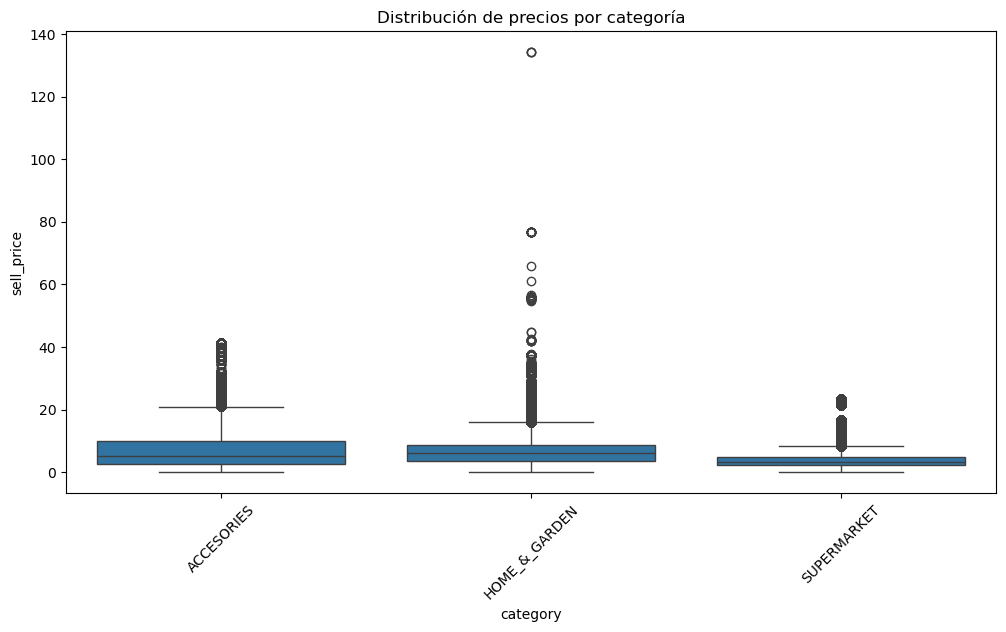

In [255]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="category", y="sell_price", data=df_prices)
plt.xticks(rotation=45)
plt.title("Distribución de precios por categoría")
plt.show()
     

In [256]:
df_prices_check = df_prices[(df_prices["category"] == "HOME_&_GARDEN") & (df_prices["sell_price"] > 75)]

In [257]:
df_prices_check

,item,category,store_code,yearweek,sell_price
5910991,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201241.0,76.825
5910992,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201242.0,76.825
5910993,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201243.0,76.825
5910994,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201244.0,76.825
5910995,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201245.0,76.825
5910996,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201246.0,76.825
5910997,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201247.0,76.825
5910998,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201248.0,76.825
5910999,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201249.0,76.825
5911000,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201250.0,76.825


In [258]:
df_pr_check = df_prices[
    (df_prices["item"] == "HOME_&_GARDEN_2_406") & 
    (df_prices["store_code"].isin([ "PHI_3"]))
]

In [259]:
pd.set_option('display.max_colwidth', None) 
df_pr_check.groupby('store_code')['sell_price'].unique()

store_code
PHI_3    [15.5875, 4.074999999999999, 15.575, 134.14999999999998]
Name: sell_price, dtype: object

In [260]:
pd.reset_option('display.max_colwidth')

In [261]:
moda_valor = df_prices.loc[(df_prices['store_code'] == 'PHI_3') & 
                           (df_prices['item'] == 'HOME_&_GARDEN_2_406'), 'sell_price'].mode()
moda_valor

0    15.575
Name: sell_price, dtype: float64

In [262]:
max_precio = df_prices.loc[(df_prices['store_code'] == 'PHI_3') & 
                           (df_prices['item'] == 'HOME_&_GARDEN_2_406'), 'sell_price'].max()
max_precio

134.14999999999998

In [263]:
df_prices.loc[(df_prices['store_code'] == 'PHI_3') & 
              (df_prices['item'] == 'HOME_&_GARDEN_2_406') & 
              (df_prices['sell_price'] == max_precio), 'sell_price'] = moda_valor

In [316]:
df_prices_check2 = df_prices[(df_prices["category"] == "HOME_&_GARDEN") & (df_prices["sell_price"] > 100)]
df_prices_check2

,item,category,store_code,yearweek,sell_price


In [265]:

filtered_df = df_prices[(df_prices['item'] == 'ACCESORIES_1_001')]
filtered_df

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858
...,...,...,...,...,...
6257108,ACCESORIES_1_001,ACCESORIES,PHI_3,NaN,11.1454
6257109,ACCESORIES_1_001,ACCESORIES,PHI_3,NaN,11.1454
6257110,ACCESORIES_1_001,ACCESORIES,PHI_3,NaN,11.1454
6257111,ACCESORIES_1_001,ACCESORIES,PHI_3,NaN,11.1454


In [266]:
filtered_df1 = df_prices[(df_prices['item'] == 'SUPERMARKET_3_827')]
filtered_df1

,item,category,store_code,yearweek,sell_price
711002,SUPERMARKET_3_827,SUPERMARKET,NYC_1,201508.0,1.2
711003,SUPERMARKET_3_827,SUPERMARKET,NYC_1,201509.0,1.2
711004,SUPERMARKET_3_827,SUPERMARKET,NYC_1,201510.0,1.2
711005,SUPERMARKET_3_827,SUPERMARKET,NYC_1,201511.0,1.2
711006,SUPERMARKET_3_827,SUPERMARKET,NYC_1,201512.0,1.2
...,...,...,...,...,...
6965701,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2
6965702,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2
6965703,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2
6965704,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2


In [267]:
pd.reset_option('display.max_rows')

In [268]:
max = df_prices['sell_price'].max()
expensiveitem = df_prices[df_prices['sell_price'] == max]
expensiveitem

,item,category,store_code,yearweek,sell_price
5910991,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201241.0,76.825
5910992,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201242.0,76.825
5910993,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201243.0,76.825
5910994,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201244.0,76.825
5910995,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201245.0,76.825
5910996,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201246.0,76.825
5910997,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201247.0,76.825
5910998,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201248.0,76.825
5910999,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201249.0,76.825
5911000,HOME_&_GARDEN_2_406,HOME_&_GARDEN,PHI_2,201250.0,76.825


In [269]:
min = df_prices['sell_price'].min()
cheapitem = df_prices[df_prices['sell_price'] == min]
cheapitem

,item,category,store_code,yearweek,sell_price
2664856,SUPERMARKET_3_413,SUPERMARKET,NYC_4,201152.0,0.012
2664857,SUPERMARKET_3_413,SUPERMARKET,NYC_4,201200.0,0.012
5413301,SUPERMARKET_3_122,SUPERMARKET,PHI_1,201429.0,0.012


## 4. Limpieza de files

### 4.1. Calendar



- Se paso la columna "date" a formato datetime
- Se identifico un problema al intentar crear una columna con el formato "yearweek" ya que utilizando solo la columna date y las formulas genericas *dt.strftime('%Y-%U')* y *dt.isocalendar()* no nos da los resultados esperados, al hacer el merge entre df_sales y df_price para la cual necesitamos el "yearweek" obtenemos NaN.
- Con las formuals anteriores observamos que las semanas comienzan el dia sabado, y esta relacionnado con el weekday_int en el df_calendar ya que el Sabado es 1, tambien se vio que todos los años tienen poco mas de 2 semanas en base a la cantidad de dias, pero en el df_price, tiene 52 semanas excepto el 2012, por lo que se puede asumir que al terminar la semana 52, comienza el proximo año (sin importar que sean los ultimos dias del año)
- Luego de investigacion y pruebas hemos visto que para crear la columna "yearweek" necesitamos una formula personalizada para que cuenta las semanas teniendo el sabado como primer dia y siendo 52 semanas al año, exepto por el 2012 que tiene 53 semanas. Al cumplirse las 52 semanas comienza el proximo año, aunque aun no haya finalizado en año en la columna date.
- Se cambiaron los NaN de la columna "event" por Regular Day
- Se agregaron las fiestas Navidad y 4 de Julio
- Se crearon diccionarios de la columna "d" con "date", "weekday", "event" y "yearweek" para luego incluir estos valores en el df_sales

In [270]:
df_calendar = df_calendar_original.copy()

In [271]:
df_calendar

,date,weekday,weekday_int,d,event
0,2011-01-29,Saturday,1,d_1,NaN
1,2011-01-30,Sunday,2,d_2,NaN
2,2011-01-31,Monday,3,d_3,NaN
3,2011-02-01,Tuesday,4,d_4,NaN
4,2011-02-02,Wednesday,5,d_5,NaN
...,...,...,...,...,...
1908,2016-04-20,Wednesday,5,d_1909,NaN
1909,2016-04-21,Thursday,6,d_1910,NaN
1910,2016-04-22,Friday,7,d_1911,NaN
1911,2016-04-23,Saturday,1,d_1912,NaN


In [272]:
#pasar columna date a formato dtime
df_calendar['date'] = pd.to_datetime(df_calendar['date'])

In [273]:
# Parámetros iniciales
start_date = pd.Timestamp('2011-01-29')  # Fecha inicial
start_year = start_date.year
start_week = 5  # Semana inicial del año 2011

# Función para calcular el yearweek
def calculate_yearweek(row):
    days_since_start = (row['date'] - start_date).days
    weeks_since_start = days_since_start // 7
    adjusted_year = start_year
    adjusted_week = start_week + weeks_since_start

    while True:
        if adjusted_year == 2012:
            weeks_in_year = 53
        else:
            weeks_in_year = 52

        if adjusted_week > weeks_in_year:
            adjusted_week -= weeks_in_year
            adjusted_year += 1
        else:
            break

    return f"{adjusted_year}{str(adjusted_week).zfill(2)}"


In [274]:
# Crear la columna yearweek
df_calendar['yearweek'] = df_calendar.apply(calculate_yearweek, axis=1)

In [275]:
df_calendar['year'] = df_calendar['yearweek'].str[:4]
df_calendar['week'] = df_calendar['yearweek'].str[4:]
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar['day'] = df_calendar['date'].dt.day



In [276]:
df_calendar

,date,weekday,weekday_int,d,event,yearweek,year,week,month,day
0,2011-01-29,Saturday,1,d_1,NaN,201105,2011,05,1,29
1,2011-01-30,Sunday,2,d_2,NaN,201105,2011,05,1,30
2,2011-01-31,Monday,3,d_3,NaN,201105,2011,05,1,31
3,2011-02-01,Tuesday,4,d_4,NaN,201105,2011,05,2,1
4,2011-02-02,Wednesday,5,d_5,NaN,201105,2011,05,2,2
...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,Wednesday,5,d_1909,NaN,201616,2016,16,4,20
1909,2016-04-21,Thursday,6,d_1910,NaN,201616,2016,16,4,21
1910,2016-04-22,Friday,7,d_1911,NaN,201616,2016,16,4,22
1911,2016-04-23,Saturday,1,d_1912,NaN,201617,2016,17,4,23


In [277]:
df_calendar = df_calendar.fillna('No_event')

In [278]:
# formulas para agregar navidad y 4 de julio
# se elimino el ramadan

df_calendar.loc[(df_calendar['month'] == 12) & (df_calendar['day'] == 25), 'event'] = 'Navidad'
df_calendar.loc[(df_calendar['month'] == 7) & (df_calendar['day'] == 4), 'event'] = '4 de Julio'
#df_calendar['event'] = df_calendar['event'].replace('Ramadan starts', 'No_event')

In [279]:
weekday_mapping = {3: 1,4: 2,5: 3,6: 4,7: 5,1: 6,2: 7}

In [280]:
df_calendar['weekday_int'] = df_calendar['weekday_int'].replace(weekday_mapping)

In [281]:
#crear diccionaron del calendar

map_dict_date = df_calendar.set_index('d')['date'].to_dict()
map_dict_yearweek = df_calendar.set_index('d')['yearweek'].to_dict()
map_dict_event = df_calendar.set_index('d')['event'].to_dict()
map_dict_weekday = df_calendar.set_index('d')['weekday_int'].to_dict()

In [282]:
df_calendar['yearweek'].nunique()

274

In [283]:
df_calendar

,date,weekday,weekday_int,d,event,yearweek,year,week,month,day
0,2011-01-29,Saturday,6,d_1,No_event,201105,2011,05,1,29
1,2011-01-30,Sunday,7,d_2,No_event,201105,2011,05,1,30
2,2011-01-31,Monday,1,d_3,No_event,201105,2011,05,1,31
3,2011-02-01,Tuesday,2,d_4,No_event,201105,2011,05,2,1
4,2011-02-02,Wednesday,3,d_5,No_event,201105,2011,05,2,2
...,...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,Wednesday,3,d_1909,No_event,201616,2016,16,4,20
1909,2016-04-21,Thursday,4,d_1910,No_event,201616,2016,16,4,21
1910,2016-04-22,Friday,5,d_1911,No_event,201616,2016,16,4,22
1911,2016-04-23,Saturday,6,d_1912,No_event,201617,2016,17,4,23


In [284]:
df_calendar.groupby('year')['week'].max()

year
2011    52
2012    53
2013    52
2014    52
2015    52
2016    17
Name: week, dtype: object

In [285]:
df_calendar['yearweek'].min()

'201105'

In [286]:
df_calendar['yearweek'].max()

'201617'

In [287]:
df_calendar['yearweek'].unique()

array(['201105', '201106', '201107', '201108', '201109', '201110',
       '201111', '201112', '201113', '201114', '201115', '201116',
       '201117', '201118', '201119', '201120', '201121', '201122',
       '201123', '201124', '201125', '201126', '201127', '201128',
       '201129', '201130', '201131', '201132', '201133', '201134',
       '201135', '201136', '201137', '201138', '201139', '201140',
       '201141', '201142', '201143', '201144', '201145', '201146',
       '201147', '201148', '201149', '201150', '201151', '201152',
       '201201', '201202', '201203', '201204', '201205', '201206',
       '201207', '201208', '201209', '201210', '201211', '201212',
       '201213', '201214', '201215', '201216', '201217', '201218',
       '201219', '201220', '201221', '201222', '201223', '201224',
       '201225', '201226', '201227', '201228', '201229', '201230',
       '201231', '201232', '201233', '201234', '201235', '201236',
       '201237', '201238', '201239', '201240', '201241', '2012

### 4.2. Sales


- Se hizo melt de las columnas "d_" para que sean filas en vez de columnas manteniendo fijas las columas desde "id" a "region"
- en primera instancia se habian eliminado las lineas con venta 0 pero hemos visto que para algunos analisis previos a la clusterizacion son necesarias las lineas sin ventas
- Se resetaron los numeros del index
- Se incluyeron las columnas de "date", "yearweek", "events" y "weekday" a partir de los diccionarios creados anteriormente

In [288]:
df_sales_original

,id,item,category,department,store,store_code,region,d_1,d_2,d_3,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,2,...,2,0,0,0,0,0,1,0,0,1
30486,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,6,0,...,2,1,0,2,0,1,0,0,1,0
30488,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [289]:
columns_sales = df_sales_original.columns[:7].to_list()
columns_sales

['id', 'item', 'category', 'department', 'store', 'store_code', 'region']

In [290]:
#Mover las ventas a filas
# id_vars = Columnas que no cambian
# var_name = Nombre para la nueva columna de fecha
# value_name = Nombre para los valores de ventas

df_sales = pd.melt(df_sales_original,id_vars=columns_sales,var_name='Fecha',value_name='Qsale')

In [291]:
#eliminar las lineas en las que las ventas son 0

#df_sales = df_sales[df_sales['Qsale'] != 0]+

In [292]:
#Resetear los numeros del indice

#df_sales = df_sales.reset_index(drop=True)

In [293]:
df_sales

,id,item,category,department,store,store_code,region,Fecha,Qsale
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0
...,...,...,...,...,...,...,...,...,...
58327365,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,1
58327366,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0
58327367,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0
58327368,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,3


In [294]:
#Agregar fecha, yearweek y event del calendar

df_sales['date'] = df_sales['Fecha'].map(map_dict_date).combine_first(df_sales['Fecha'])
df_sales['yearweek'] = df_sales['Fecha'].map(map_dict_yearweek).combine_first(df_sales['Fecha'])
df_sales['event'] = df_sales['Fecha'].map(map_dict_event).combine_first(df_sales['Fecha'])
df_sales['weekday'] = df_sales['Fecha'].map(map_dict_weekday).combine_first(df_sales['Fecha'])


C:\Users\gaspi\AppData\Local\Temp\ipykernel_16796\2103031368.py:6: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_sales['weekday'] = df_sales['Fecha'].map(map_dict_weekday).combine_first(df_sales['Fecha'])


In [295]:
df_sales

,id,item,category,department,store,store_code,region,Fecha,Qsale,date,yearweek,event,weekday
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,1,2016-04-24,201617,No_event,7
58327366,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0,2016-04-24,201617,No_event,7
58327367,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0,2016-04-24,201617,No_event,7
58327368,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,3,2016-04-24,201617,No_event,7


### 4.3. Prices

- Se actualizaron los NaN en la columnas de "yearweek" con una formula personalizada
- Se cambio el formato de la columna "yearweek" para eliminar el .0

In [296]:
df_prices

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328.0,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329.0,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330.0,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331.0,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332.0,10.9858
...,...,...,...,...,...
6965701,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000
6965702,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000
6965703,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000
6965704,SUPERMARKET_3_827,SUPERMARKET,PHI_3,NaN,1.2000


In [297]:
df_prices.dropna(inplace=True)


In [298]:
#pasar yearweek a str, primero lo paso a int para que no tenga el .0

df_prices['yearweek'] = df_prices['yearweek'].astype(int)
df_prices['yearweek'] = df_prices['yearweek'].astype(str)

In [299]:
df_prices

,item,category,store_code,yearweek,sell_price
0,ACCESORIES_1_001,ACCESORIES,NYC_1,201328,12.7414
1,ACCESORIES_1_001,ACCESORIES,NYC_1,201329,12.7414
2,ACCESORIES_1_001,ACCESORIES,NYC_1,201330,10.9858
3,ACCESORIES_1_001,ACCESORIES,NYC_1,201331,10.9858
4,ACCESORIES_1_001,ACCESORIES,NYC_1,201332,10.9858
...,...,...,...,...,...
6965693,SUPERMARKET_3_827,SUPERMARKET,PHI_3,201613,1.2000
6965694,SUPERMARKET_3_827,SUPERMARKET,PHI_3,201614,1.2000
6965695,SUPERMARKET_3_827,SUPERMARKET,PHI_3,201615,1.2000
6965696,SUPERMARKET_3_827,SUPERMARKET,PHI_3,201616,1.2000


## 5. Merge Prices y Sales

### 5.1. Merge para incluir el sell_price en df_sales

- Se incluye la columna "sell_price" del df_prices en el df_sales a partir de las columnas "item", "store_code" y "yearweek".


In [300]:
df_sales_wprice = df_sales.merge(df_prices[['item','store_code', 'yearweek', 'sell_price']], on=['item','store_code', 'yearweek'], how='left')

### 5.2. Check para ver que no hay NaN de Sell_price luego del merge


- En este punto se verifica que si hay o no NaN al incluir el "sell_price" en el df_sale, si hay NaN es porque la formula de "yearweek" no es correcta, en caso de que haya valores nulos ver si hay algun patron en los dias en los que hay errores
- Este punto nos sirvo para identificar que los errores que teniamos se generaban los ultimos dias del mes de Diciembre en la mayoria de los años
- Se observa que las lineas con valores nulos en el sell_price son lineas en las que no hay ventas, por lo que se creo una formula para completar el sell price, teniendo en cuenta el ultimo valor disponible, si no hay valor previo se utilizara el posterior
- Se observa que la formula funciona correctamente, y no hay valores nulos


In [301]:
nan_rows_specific = df_sales_wprice[df_sales_wprice['sell_price'].isna()]

In [302]:
nan_rows_specific

,id,item,category,department,store,store_code,region,Fecha,Qsale,date,yearweek,event,weekday,sell_price
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,NaN
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,NaN
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,NaN
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,NaN
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56108534,HOME_&_GARDEN_1_278_NYC_3,HOME_&_GARDEN_1_278,HOME_&_GARDEN,HOME_&_GARDEN_1,Tribeca,NYC_3,New York,d_1841,0,2016-02-12,201606,No_event,5,NaN
56110517,SUPERMARKET_3_595_NYC_3,SUPERMARKET_3_595,SUPERMARKET,SUPERMARKET_3,Tribeca,NYC_3,New York,d_1841,0,2016-02-12,201606,No_event,5,NaN
56111702,HOME_&_GARDEN_1_400_NYC_4,HOME_&_GARDEN_1_400,HOME_&_GARDEN,HOME_&_GARDEN_1,Brooklyn,NYC_4,New York,d_1841,0,2016-02-12,201606,No_event,5,NaN
56123886,HOME_&_GARDEN_1_386_PHI_1,HOME_&_GARDEN_1_386,HOME_&_GARDEN,HOME_&_GARDEN_1,Midtown_Village,PHI_1,Philadelphia,d_1841,0,2016-02-12,201606,No_event,5,NaN


In [303]:
nan_rows_specific['Qsale'].sum()

1

In [304]:
valores_unicos = nan_rows_specific['date'].unique()
valores_unicos

<DatetimeArray>
['2011-01-29 00:00:00', '2011-01-30 00:00:00', '2011-01-31 00:00:00',
 '2011-02-01 00:00:00', '2011-02-02 00:00:00', '2011-02-03 00:00:00',
 '2011-02-04 00:00:00', '2011-02-05 00:00:00', '2011-02-06 00:00:00',
 '2011-02-07 00:00:00',
 ...
 '2016-02-03 00:00:00', '2016-02-04 00:00:00', '2016-02-05 00:00:00',
 '2016-02-06 00:00:00', '2016-02-07 00:00:00', '2016-02-08 00:00:00',
 '2016-02-09 00:00:00', '2016-02-10 00:00:00', '2016-02-11 00:00:00',
 '2016-02-12 00:00:00']
Length: 1841, dtype: datetime64[ns]

In [305]:
valores_unicos_cant = nan_rows_specific['Qsale'].unique()
valores_unicos_cant

array([0, 1], dtype=int64)

In [306]:
df_sales_wprice['sell_price'] = df_sales_wprice.groupby('id')['sell_price'].apply(lambda x: x.ffill().bfill()).reset_index(level=0, drop=True)

In [307]:
nan_rows_specific2 = df_sales_wprice[df_sales_wprice['sell_price'].isna()]

In [308]:
nan_rows_specific2

,id,item,category,department,store,store_code,region,Fecha,Qsale,date,yearweek,event,weekday,sell_price


## 6. Df_sales_wprice

- Se observan los valores unicos de 'category','department','store','region','event'
- Se crear la columna de total_venta en el nuevo df para calcular el total por linea (Qsale*sell_price)
- Se eliminan las columnas "id", "store_code" y "Fecha" ya que no aportan datos de valor y para que el archivo output ocupe menos espacio
- Renombrado de columnas
- Se crea un nuevo archivo csv a partir de este nuevo df para trabajar en los proximos pasos del proyecto sin la necesidad de ejecturar la limpieza y merge de datos
- Luego de investigacion vimos que es mas conveniente exportar el df como pickel ya que ocupa menos espacio, y es mas eficiente para su lectura en este formato

- Se podria cambiar la columna weekday por un flag de dia de fin de semana y cambiar la columna de event por uno de flags ( columnas de 1 y 0)


In [309]:
df_sales_wprice

,id,item,category,department,store,store_code,region,Fecha,Qsale,date,yearweek,event,weekday,sell_price
0,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,12.7414
1,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,5.2801
2,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,3.9501
3,ACCESORIES_1_004_NYC_1,ACCESORIES_1_004,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,5.7722
4,ACCESORIES_1_005_NYC_1,ACCESORIES_1_005,ACCESORIES,ACCESORIES_1,Greenwich_Village,NYC_1,New York,d_1,0,2011-01-29,201105,No_event,6,3.9634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58327365,SUPERMARKET_3_823_PHI_3,SUPERMARKET_3_823,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,1,2016-04-24,201617,No_event,7,3.5760
58327366,SUPERMARKET_3_824_PHI_3,SUPERMARKET_3_824,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0,2016-04-24,201617,No_event,7,2.9760
58327367,SUPERMARKET_3_825_PHI_3,SUPERMARKET_3_825,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,0,2016-04-24,201617,No_event,7,4.7760
58327368,SUPERMARKET_3_826_PHI_3,SUPERMARKET_3_826,SUPERMARKET,SUPERMARKET_3,Queen_Village,PHI_3,Philadelphia,d_1913,3,2016-04-24,201617,No_event,7,1.5360


In [310]:
for i in ['category','department','store','region','event']:
  print(f'\n{i}\n{df_sales_wprice[i].unique()}')


category
['ACCESORIES' 'HOME_&_GARDEN' 'SUPERMARKET']

department
['ACCESORIES_1' 'ACCESORIES_2' 'HOME_&_GARDEN_1' 'HOME_&_GARDEN_2'
 'SUPERMARKET_1' 'SUPERMARKET_2' 'SUPERMARKET_3']

store
['Greenwich_Village' 'Harlem' 'Tribeca' 'Brooklyn' 'South_End' 'Roxbury'
 'Back_Bay' 'Midtown_Village' 'Yorktown' 'Queen_Village']

region
['New York' 'Boston' 'Philadelphia']

event
['No_event' 'SuperBowl' '4 de Julio' 'Ramadan starts' 'Thanksgiving'
 'Navidad' 'NewYear' 'Easter']


In [311]:
#Creado de columna total venta Qsale*sell_price
df_sales_wprice['total_venta'] = df_sales_wprice['Qsale']*df_sales_wprice['sell_price']

In [312]:
df_sales_wprice.drop(columns=['Fecha','id','store_code'], inplace=True)

In [313]:
df_sales_wprice.rename(columns={'region': 'city', 'sell_price': 'unit_price'}, inplace=True)

In [314]:
with open('df_sales_wprice.pkl', 'wb') as file:  
    pickle.dump(df_sales_wprice, file)      